In [1]:
from atl_module import kriging
import geopandas as gpd
from atl_module import GebcoUpscaler
import rasterio as rio
from shapely.geometry import box

In [2]:
%cd ..


/mnt/c/Users/maxli/OneDrive - Van Oord/Documents/thesis/code


In [3]:
jarkuspts = gpd.read_file('../data/jarkus/jarkus-2021_Noord-Holland.gpkg')


In [4]:
jarkuspts = jarkuspts.assign(X=jarkuspts.geometry.x,Y=jarkuspts.geometry.y)

In [5]:
truth = rio.open('../data/special_sites/petten/in-situ-DEM/truth.vrt')
truthrascrs= truth.crs
truth_ras_bounds = truth.bounds

In [6]:
subset_jarkus = jarkuspts.to_crs(truthrascrs).clip(truth_ras_bounds).to_crs(jarkuspts.estimate_utm_crs())
# add the location in local UTM system as a columns
subset_jarkus = subset_jarkus.assign(northing=subset_jarkus.geometry.y,easting=subset_jarkus.geometry.x,sf_elev_MSL=subset_jarkus.geometry.z).loc[:,['X','Y','northing','easting','sf_elev_MSL','geometry']]
sub_jarkus = subset_jarkus[subset_jarkus.sf_elev_MSL < 1]

In [7]:
subset_jarkus.to_file('../data/special_sites/petten/all_bathy_pts.gpkg')

In [8]:
site = GebcoUpscaler('../data/special_sites/petten','Petten','../data/special_sites/petten/in-situ-DEM/truth.vrt')

In [9]:
site.subset_gebco(50)

[D 220919 02:30:10 raster_interaction:128] GEBCO subset raster written to ../data/special_sites/petten/bilinear.tif, with CRS EPSG:32631


In [10]:
%%time
site.kriging(
    kr_model='uk',
    npts=2000,
    variogram_parameters={'range':10000,'nugget':0.7,'sill':23},
    samplemethod='dart'
    )

[I 220919 02:30:10 core:194] Kriging Petten site using 2000 points with crs epsg:32631 with options {'variogram_parameters': {'range': 10000, 'nugget': 0.7, 'sill': 23}, 'samplemethod': 'dart'}
[D 220919 02:30:12 kriging:23] The types of the numpy array that is sent to PDAL poisson dart throwing are: (numpy.record, [('Y', '<f8'), ('X', '<f8'), ('Z', '<f8')])
[D 220919 02:30:12 kriging:29] 2000 points remaining after relaxation dart throwing culling
[D 220919 02:30:13 kriging:71] 2000 points selected with dart written to ../data/special_sites/petten/kriging_pts


Adjusting data for anisotropy...
Initializing variogram model...
Using 'spherical' Variogram Model
Partial Sill: 22.3
Full Sill: 23.0
Range: 10000
Nugget: 0.7 

Calculating statistics on variogram model fit...
Q1 = 0.010970558987859631
Q2 = 4.0510144545902635
cR = 5.061498516531757 

Initializing drift terms...
Executing Universal Kriging...



[D 220919 02:39:26 kriging:126] finished kriging, now saving the output raster to ../data/special_sites/petten/kriging_output.tif
[D 220919 02:39:27 kriging:144] Output raster of kriged Z values and uncertainty saved sucessfully


CPU times: user 1h 3min 28s, sys: 26min 34s, total: 1h 30min 2s
Wall time: 9min 16s


In [11]:
site.kalman_update(1.5)
site.raster_rmse(check_kriged=True)

[I 220919 02:39:27 kalman:72] Wrote Kalman Updated Raster with GEBCO uncertainty 1.5 to ../data/special_sites/petten/kalman_updated.tif
[I 220919 02:39:27 core:227] Sucessful Kalman update of GEBCO bathymetry for Petten using a gebco standard deviation of 1.5 saved to ../data/special_sites/petten/kalman_updated.tif
/mnt/c/Users/maxli/OneDrive - Van Oord/Documents/thesis/code/atl_module/error_calc.py:172: RuntimeWarning: Mean of empty slice
  mse = np.nanmean(error_data**2)
/mnt/c/Users/maxli/OneDrive - Van Oord/Documents/thesis/code/atl_module/error_calc.py:174: RuntimeWarning: Mean of empty slice
  mae = np.nanmean(np.abs(error_data))
[I 220919 02:40:49 core:296] site:Petten - {"RMSE":{"Naive Bilinear Interpolation":1.4757187466,"Kalman Updated Raster":0.9668572301,"Kriged Raster":1.1405451498},"MAE":{"Naive Bilinear Interpolation":1.3139332533,"Kalman Updated Raster":0.7460160255,"Kriged Raster":0.6753032207}}


,RMSE,MAE
Naive Bilinear Interpolation,1.475719,1.313933
Kalman Updated Raster,0.966857,0.746016
Kriged Raster,1.140545,0.675303


In [12]:
site.bathy_pts_gdf = site.bathy_pts_gdf.assign(easting_corr=0,northing_corr=0)
site.add_truth_data()

[I 220919 02:41:36 core:255] Truth data added to Bathymetric Points dataframe for site: Petten


In [13]:
site.lidar_error()

[I 220919 02:41:36 core:236] Petten: RMSE between icesat and truth 0.46928823888558663, MAE: 0.29491203201446353


,MAE,RMSE,Median Abs error,R2 Score,Average Error
Petten,0.294912,0.469288,0.145,0.995713,-0.038357


[I 220919 02:41:37 core:334] Petten: Saved lidar error plot to ../document/figures/Petten_lidar_estimated_vs_truth.jpg


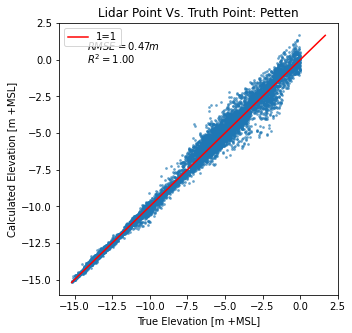

In [14]:
site.bathy_pts_gdf = site.bathy_pts_gdf[site.bathy_pts_gdf.true_elevation <0]
site.plot_lidar_error()

In [15]:
site.

SyntaxError: invalid syntax (1705002862.py, line 1)